# Assignment 4: Cell Nuclei Separation — Watershed Segmentation

**Task:** Separate touching/overlapping nuclei in histology images  
**Methods:** Marker-controlled watershed (with markers) vs. plain watershed (without markers)  
**Dataset:** Kaggle — MonuSeg-2018 (training images: .tif, masks: .png)  
**Compare:** With vs without markers  
**Learning:** Over-segmentation control

In [57]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import morphology, measure, segmentation, filters, color
from skimage.morphology import disk, remove_small_objects, binary_erosion
from skimage.segmentation import watershed, mark_boundaries
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings('ignore')
print('Libraries loaded')

Libraries loaded


## 1. Dataset Loading

MonuSeg-2018 structure:
- `kmms_training/kmms_training/images/` → `.tif` files (histology images)
- `kmms_training/kmms_training/masks/` → `.png` files (binary nucleus masks)
- `kmms_test/kmms_test/images/` → `.png` files (test images)
- `kmms_test/kmms_test/masks/` → `.png` files (test masks)

In [58]:
base_path = '/kaggle/input/datasets/tuanledinh/monuseg2018'

# Find all image files
tif_files = glob.glob(os.path.join(base_path, '**', '*.tif'), recursive=True)
png_files = glob.glob(os.path.join(base_path, '**', '*.png'), recursive=True)

print(f'TIF files: {len(tif_files)}')
print(f'PNG files: {len(png_files)}')

# Show organization
from collections import defaultdict
by_folder = defaultdict(list)
for f in tif_files + png_files:
    folder = os.path.relpath(os.path.dirname(f), base_path)
    by_folder[folder].append(os.path.basename(f))

for folder in sorted(by_folder.keys()):
    files = by_folder[folder]
    exts = set(os.path.splitext(f)[1] for f in files)
    print(f'  {folder}: {len(files)} files {exts}')

TIF files: 32
PNG files: 132
  kmms_test/kmms_test/images: 58 files {'.tif', '.png'}
  kmms_test/kmms_test/masks: 58 files {'.png'}
  kmms_training/kmms_training/images: 24 files {'.tif'}
  kmms_training/kmms_training/masks: 24 files {'.png'}


In [59]:
def load_monuseg(base_path):
    """
    Load MonuSeg training data.
    Training images are .tif, masks are .png.
    Returns list of dicts with 'image' (RGB), 'mask' (binary), 'name'.
    """
    # Training images are .tif
    train_img_dir = os.path.join(base_path, 'kmms_training', 'kmms_training', 'images')
    train_mask_dir = os.path.join(base_path, 'kmms_training', 'kmms_training', 'masks')

    image_files = sorted(glob.glob(os.path.join(train_img_dir, '*.tif')))

    if not image_files:
        # Fallback: search recursively
        image_files = sorted(glob.glob(os.path.join(base_path, '**', '*.tif'), recursive=True))

    data = []
    for img_path in image_files:
        name = os.path.splitext(os.path.basename(img_path))[0]

        # Load .tif image with PIL (handles multi-page TIF)
        with Image.open(img_path) as img:
            img_rgb = np.array(img.convert('RGB'))

        # Find corresponding mask (.png)
        mask_path = os.path.join(train_mask_dir, name + ' .png')
        # print(mask_path)
        if not os.path.exists(mask_path):
            # Try searching
            candidates = glob.glob(os.path.join(base_path, '**', name + '.png'), recursive=True)
            mask_path = candidates[0] if candidates else None
        
        mask = None
        if mask_path and os.path.exists(mask_path):
            
            with Image.open(mask_path) as mimg:
                mask = np.array(mimg.convert('L')) > 0

        data.append({'name': name, 'image': img_rgb, 'mask': mask})

    return data


dataset = load_monuseg(base_path)
print(f'Loaded {len(dataset)} training images')
if dataset:
    s = dataset[0]
    print(f'  Image shape: {s["image"].shape}')
    print(f'  Has mask: {s["mask"] is not None}')
    if s['mask'] is not None:
        print(f'  Mask shape: {s["mask"].shape}')
        print(f'  Mask coverage: {s["mask"].sum() / s["mask"].size * 100:.1f}%')

Loaded 24 training images
  Image shape: (1000, 1000, 3)
  Has mask: True
  Mask shape: (256, 256)
  Mask coverage: 65.3%


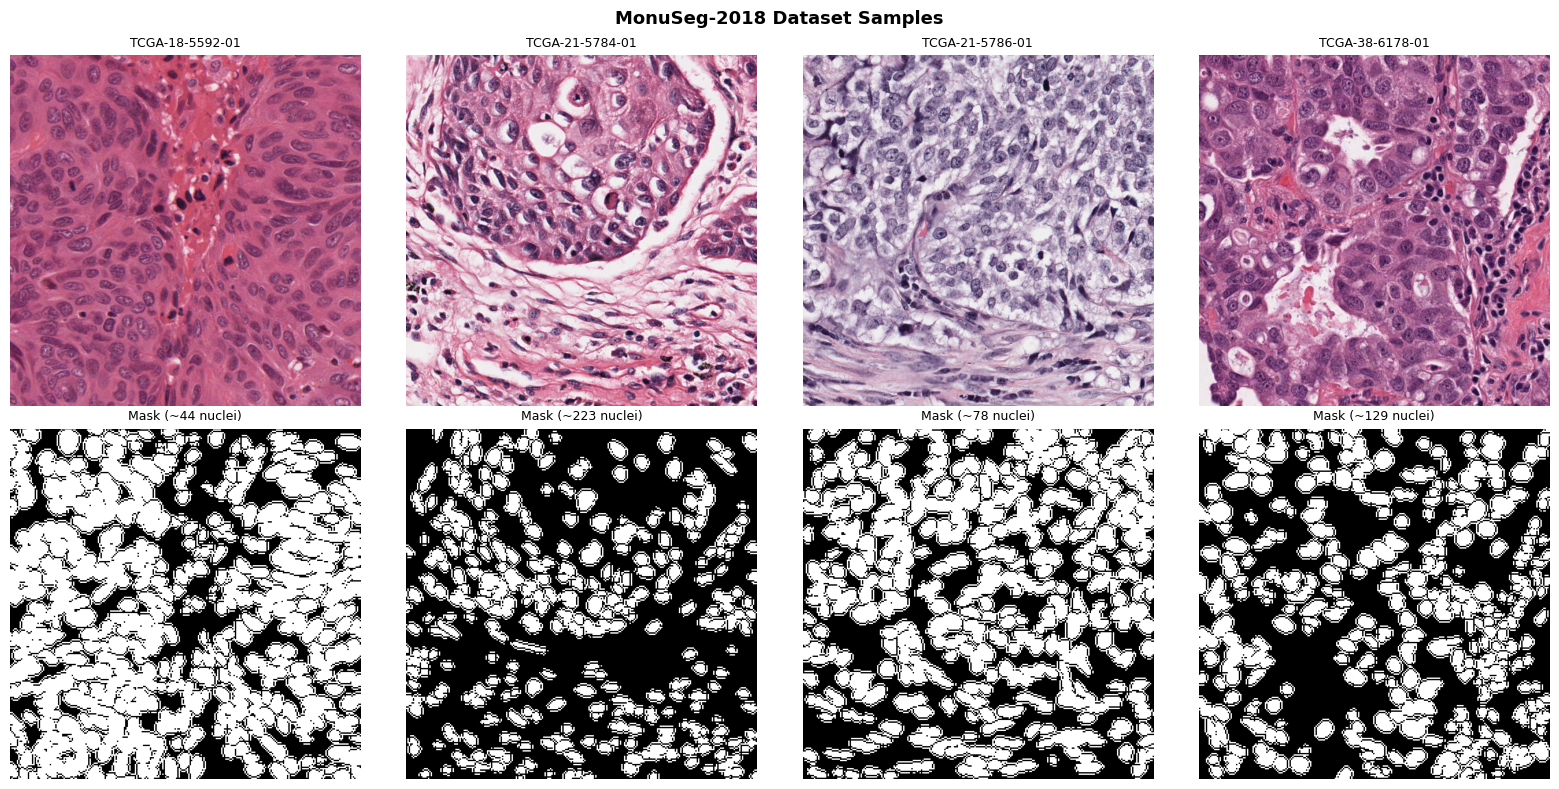

In [60]:
# Display sample images
n_show = min(4, len(dataset))
fig, axes = plt.subplots(2, n_show, figsize=(4*n_show, 8))
if n_show == 1:
    axes = axes.reshape(2, 1)

for i in range(n_show):
    s = dataset[i]
    axes[0, i].imshow(s['image'])
    axes[0, i].set_title(f'{s["name"][:15]}', fontsize=9)
    axes[0, i].axis('off')
    if s['mask'] is not None:
        axes[1, i].imshow(s['mask'], cmap='gray')
        # Count nuclei instances using connected components
        labeled = measure.label(s['mask'])
        n_nuclei = labeled.max()
        axes[1, i].set_title(f'Mask (~{n_nuclei} nuclei)', fontsize=9)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('H&E Image', fontweight='bold')
axes[1, 0].set_ylabel('Binary Mask', fontweight='bold')
plt.suptitle('MonuSeg-2018 Dataset Samples', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Preprocessing — Binary Segmentation

Before watershed, we need a binary mask separating nuclei from background. Since we have ground truth masks in this dataset, we use them directly. We also demonstrate how to obtain binary masks from raw images using color-based thresholding (hematoxylin channel).

Binary mask: 45724 foreground pixels
Initial connected components: 6


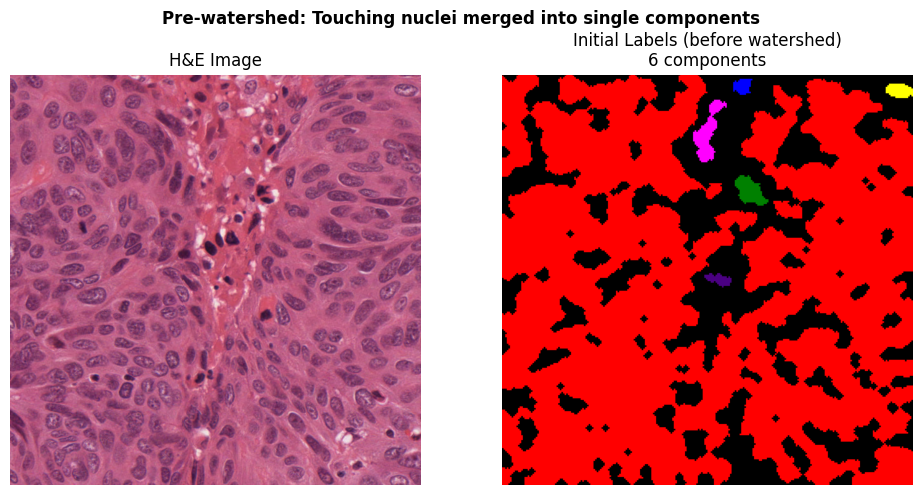

In [61]:
def get_binary_mask(entry, use_gt=True):
    """
    Get binary nucleus mask.
    If GT available and use_gt=True: use ground truth mask.
    Otherwise: segment using color thresholding on H&E stain.
    """
    if use_gt and entry['mask'] is not None:
        binary = entry['mask'].copy()
    else:
        img_rgb = entry['image']
        # H&E stain: nuclei are dark purple/blue
        # Convert to LAB, use inverse of L channel
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l_channel = img_lab[:, :, 0].astype(float)
        # Otsu threshold on inverted L (nuclei = dark = low L)
        inv_l = 255 - l_channel
        thresh = filters.threshold_otsu(inv_l)
        binary = inv_l > thresh

    # Clean up: remove very small objects
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.binary_closing(binary, disk(2))

    return binary


sample = dataset[0]
binary = get_binary_mask(sample, use_gt=True)
print(f'Binary mask: {binary.sum()} foreground pixels')

# Count touching nuclei clusters
labeled_init = measure.label(binary)
props = measure.regionprops(labeled_init)
print(f'Initial connected components: {len(props)}')

# Show a crop with touching nuclei
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample['image']); ax[0].set_title('H&E Image'); ax[0].axis('off')
ax[1].imshow(color.label2rgb(labeled_init, bg_label=0))
ax[1].set_title(f'Initial Labels (before watershed)\n{len(props)} components'); ax[1].axis('off')
plt.suptitle('Pre-watershed: Touching nuclei merged into single components', fontweight='bold')
plt.tight_layout()
plt.savefig('pre_watershed.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Watershed WITHOUT Markers (Naive Approach)

Plain watershed on the distance transform will over-segment — every local maximum becomes a separate region. This is the baseline we compare against.

In [62]:
def watershed_without_markers(binary):
    """
    Watershed WITHOUT explicit markers.
    Uses ALL local maxima of distance transform as seeds.
    Problem: many spurious maxima → over-segmentation.
    """
    # Distance transform: each pixel = distance to nearest background
    dist_transform = ndi.distance_transform_edt(binary)

    # Find ALL local maxima (no minimum distance filtering)
    local_maxima = peak_local_max(
        dist_transform,
        min_distance=1,  # Accept maxima very close together → many spurious seeds
        labels=binary
    )

    # Create marker image
    markers = np.zeros_like(binary, dtype=int)
    markers[tuple(local_maxima.T)] = 1
    markers = measure.label(markers)

    n_seeds = markers.max()

    # Apply watershed
    labels = watershed(-dist_transform, markers=markers, mask=binary)

    return labels, dist_transform, markers, n_seeds


labels_no_marker, dist_t, markers_no, n_seeds_no = watershed_without_markers(binary)
n_nuclei_no = labels_no_marker.max()
print(f'WITHOUT markers: {n_seeds_no} seeds → {n_nuclei_no} detected nuclei')

WITHOUT markers: 461 seeds → 461 detected nuclei


## 4. Marker-Controlled Watershed (Proper Approach)

We suppress spurious maxima by requiring a **minimum distance** between peaks. This ensures each nucleus gets exactly one seed marker, preventing over-segmentation.

In [63]:
def watershed_with_markers(binary, min_distance=10):
    """
    Marker-controlled watershed.
    min_distance: minimum pixels between seed markers (controls over-segmentation).
    
    Strategy:
    1. Compute distance transform
    2. Find peaks with min_distance threshold (one peak per nucleus)
    3. Use peaks as markers for watershed
    """
    # Distance transform
    dist_transform = ndi.distance_transform_edt(binary)

    # Find peaks with minimum separation — key difference from naive approach
    local_maxima = peak_local_max(
        dist_transform,
        min_distance=min_distance,  # Enforce minimum separation between seeds
        labels=binary
    )

    # Create markers
    markers = np.zeros_like(binary, dtype=int)
    markers[tuple(local_maxima.T)] = 1
    markers = measure.label(markers)

    n_seeds = markers.max()

    # Apply watershed using negative distance (watershed fills from valleys up)
    labels = watershed(-dist_transform, markers=markers, mask=binary)

    return labels, dist_transform, markers, n_seeds


labels_with_marker, dist_t, markers_with, n_seeds_with = watershed_with_markers(binary, min_distance=10)
n_nuclei_with = labels_with_marker.max()
print(f'WITH markers (min_dist=10): {n_seeds_with} seeds → {n_nuclei_with} detected nuclei')

WITH markers (min_dist=10): 66 seeds → 66 detected nuclei


## 5. Visualization — Key Comparison

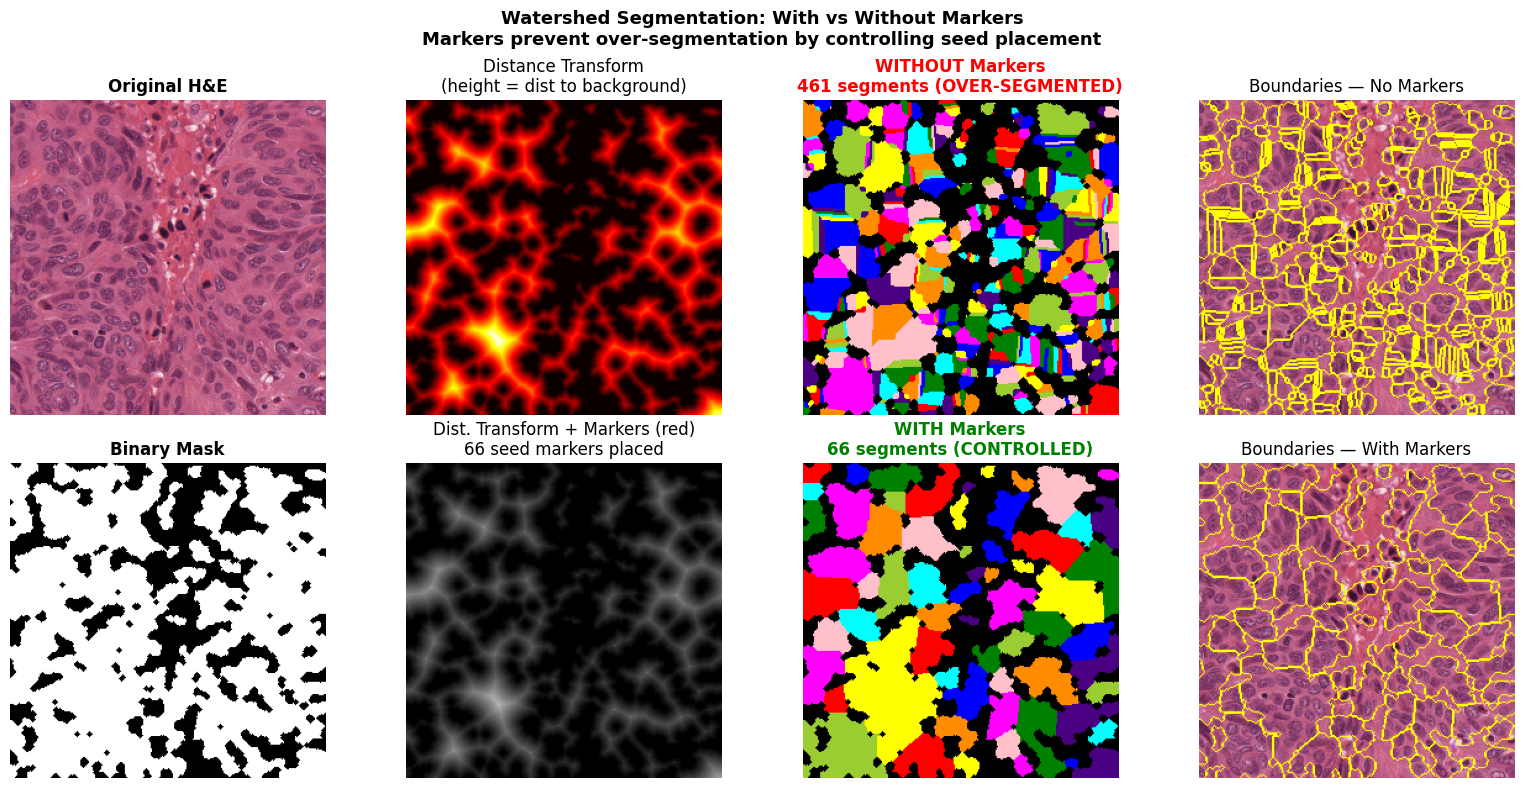

In [64]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: WITHOUT markers
axes[0,0].imshow(img_rgb); axes[0,0].set_title('Original H&E', fontweight='bold')
axes[0,1].imshow(dist_t, cmap='hot')
axes[0,1].set_title('Distance Transform\n(height = dist to background)')

axes[0,2].imshow(color.label2rgb(labels_no_marker, bg_label=0))
axes[0,2].set_title(f'WITHOUT Markers\n{n_nuclei_no} segments (OVER-SEGMENTED)', color='red', fontweight='bold')

axes[0,3].imshow(mark_boundaries(img_rgb, labels_no_marker))
axes[0,3].set_title('Boundaries — No Markers')

# Row 2: WITH markers
axes[1,0].imshow(binary, cmap='gray'); axes[1,0].set_title('Binary Mask', fontweight='bold')

# Show marker positions on distance transform
dist_with_markers = dist_t.copy()
marker_vis = np.zeros((*binary.shape, 3), dtype=np.uint8)
marker_vis[markers_with > 0] = [255, 0, 0]
dt_rgb = cv2.normalize(dist_t, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
dt_rgb = cv2.cvtColor(dt_rgb, cv2.COLOR_GRAY2RGB)
dt_with_m = cv2.addWeighted(dt_rgb, 0.7, marker_vis, 0.3, 0)
axes[1,1].imshow(dt_with_m)
axes[1,1].set_title(f'Dist. Transform + Markers (red)\n{n_seeds_with} seed markers placed')

axes[1,2].imshow(color.label2rgb(labels_with_marker, bg_label=0))
axes[1,2].set_title(f'WITH Markers\n{n_nuclei_with} segments (CONTROLLED)', color='green', fontweight='bold')

axes[1,3].imshow(mark_boundaries(img_rgb, labels_with_marker))
axes[1,3].set_title('Boundaries — With Markers')

for ax in axes.flat: ax.axis('off')

plt.suptitle('Watershed Segmentation: With vs Without Markers\n'
             'Markers prevent over-segmentation by controlling seed placement',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('watershed_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [65]:
def evaluate_segmentation(labels_pred, gt_mask):
    """
    Evaluate watershed segmentation against ground truth mask.
    Computes pixel-level metrics + nuclei count accuracy.
    """
    # Binary prediction (any labeled region = foreground)
    pred_binary = labels_pred > 0

    # Pixel-level metrics
    tp = (pred_binary & gt_mask).sum()
    fp = (pred_binary & ~gt_mask).sum()
    fn = (~pred_binary & gt_mask).sum()
    tn = (~pred_binary & ~gt_mask).sum()

    precision = tp / max(tp+fp, 1)
    recall = tp / max(tp+fn, 1)
    f1 = 2*tp / max(2*tp+fp+fn, 1)
    dice = 2*tp / max(2*tp+fp+fn, 1)  # same as F1 for binary
    jaccard = tp / max(tp+fp+fn, 1)

    # Nuclei count from GT
    gt_labeled = measure.label(gt_mask)
    gt_count = gt_labeled.max()
    pred_count = labels_pred.max()

    return {
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'dice': float(dice),
        'jaccard': float(jaccard),
        'gt_nuclei_count': int(gt_count),
        'pred_nuclei_count': int(pred_count),
        'count_error': int(pred_count - gt_count),
        'count_error_pct': float((pred_count - gt_count) / max(gt_count, 1) * 100)
    }


if sample['mask'] is not None:
    gt = sample['mask']
    metrics_no = evaluate_segmentation(labels_no_marker, gt)
    metrics_with = evaluate_segmentation(labels_with_marker, gt)

    print('EVALUATION RESULTS (single image)')
    print('=' * 60)
    print(f'{"Metric":<30} {"No Markers":>12} {"With Markers":>12}')
    print('-' * 60)
    for k in ['precision','recall','f1','dice','jaccard','gt_nuclei_count',
               'pred_nuclei_count','count_error','count_error_pct']:
        nv = metrics_no.get(k, '-')
        wv = metrics_with.get(k, '-')
        if isinstance(nv, float):
            print(f'{k:<30} {nv:>12.4f} {wv:>12.4f}')
        else:
            print(f'{k:<30} {str(nv):>12} {str(wv):>12}')
else:
    print('No ground truth mask available for this sample')

EVALUATION RESULTS (single image)
Metric                           No Markers With Markers
------------------------------------------------------------
precision                            0.8722       0.8722
recall                               0.9317       0.9317
f1                                   0.9010       0.9010
dice                                 0.9010       0.9010
jaccard                              0.8198       0.8198
gt_nuclei_count                          44           44
pred_nuclei_count                       461           66
count_error                             417           22
count_error_pct                    947.7273      50.0000


## 8. Full Dataset Evaluation

In [66]:
import pandas as pd

all_results = []
print('Evaluating on all training images...')

for entry in dataset:
    binary_i = get_binary_mask(entry, use_gt=True)

    lbl_no, _, _, _ = watershed_without_markers(binary_i)
    lbl_with, _, _, _ = watershed_with_markers(binary_i, min_distance=10)

    row = {'name': entry['name']}

    if entry['mask'] is not None:
        m_no = evaluate_segmentation(lbl_no, entry['mask'])
        m_with = evaluate_segmentation(lbl_with, entry['mask'])
        for k, v in m_no.items(): row[f'no_{k}'] = v
        for k, v in m_with.items(): row[f'with_{k}'] = v
    else:
        row['no_pred_count'] = lbl_no.max()
        row['with_pred_count'] = lbl_with.max()

    all_results.append(row)
    print(f'  {entry["name"]}: no_markers={lbl_no.max()} segs, with_markers={lbl_with.max()} segs')

df = pd.DataFrame(all_results)
print(f'\nEvaluated {len(df)} images')

Evaluating on all training images...
  TCGA-18-5592-01Z-00-DX1: no_markers=461 segs, with_markers=66 segs
  TCGA-21-5784-01Z-00-DX1: no_markers=447 segs, with_markers=87 segs
  TCGA-21-5786-01Z-00-DX1: no_markers=579 segs, with_markers=83 segs
  TCGA-38-6178-01Z-00-DX1: no_markers=554 segs, with_markers=87 segs
  TCGA-49-4488-01Z-00-DX1: no_markers=547 segs, with_markers=69 segs
  TCGA-50-5931-01Z-00-DX1: no_markers=487 segs, with_markers=68 segs
  TCGA-AY-A8YK-01A-01-TS1: no_markers=463 segs, with_markers=70 segs
  TCGA-B0-5698-01Z-00-DX1: no_markers=429 segs, with_markers=88 segs
  TCGA-B0-5710-01Z-00-DX1: no_markers=444 segs, with_markers=82 segs
  TCGA-B0-5711-01Z-00-DX1: no_markers=413 segs, with_markers=99 segs
  TCGA-CH-5767-01Z-00-DX1: no_markers=476 segs, with_markers=76 segs
  TCGA-DK-A2I6-01A-01-TS1: no_markers=569 segs, with_markers=102 segs
  TCGA-G2-A2EK-01A-02-TSB: no_markers=459 segs, with_markers=85 segs
  TCGA-G9-6336-01Z-00-DX1: no_markers=510 segs, with_markers=74 s

FULL DATASET SUMMARY
f1                             No=  0.8330  With=  0.8257
dice                           No=  0.8330  With=  0.8257
jaccard                        No=  0.7196  With=  0.7097
precision                      No=  0.8548  With=  0.8542
recall                         No=  0.8227  With=  0.8110
count_error_pct                No=550.0843  With= -5.6738


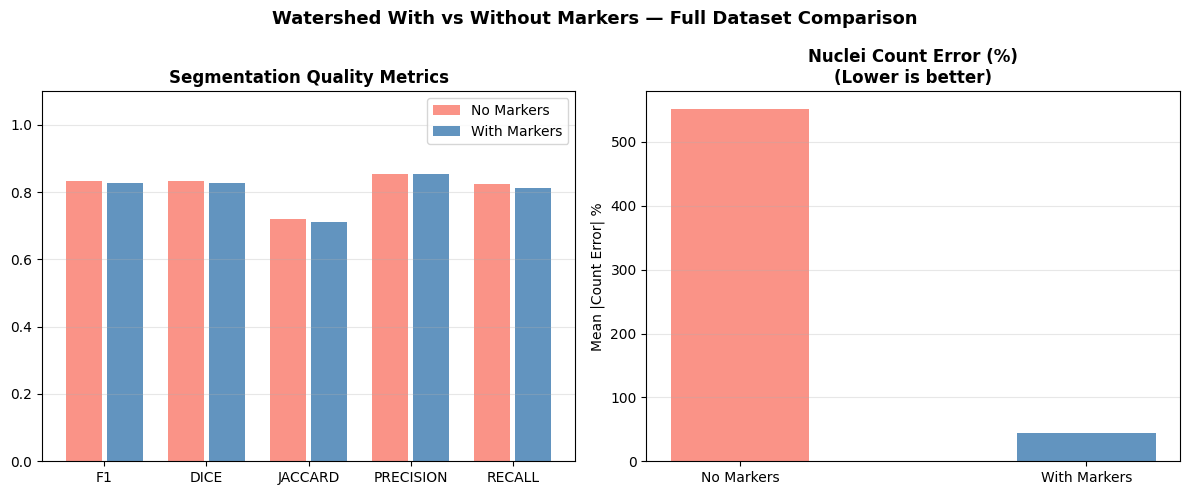

In [67]:
# Summary statistics
print('FULL DATASET SUMMARY')
print('=' * 65)

if 'no_f1' in df.columns:
    compare_keys = ['f1','dice','jaccard','precision','recall','count_error_pct']
    for k in compare_keys:
        nk, wk = f'no_{k}', f'with_{k}'
        if nk in df.columns:
            print(f'{k:<30} No={df[nk].mean():>8.4f}  With={df[wk].mean():>8.4f}')
elif 'no_pred_count' in df.columns:
    print(f'{"Nuclei count without markers":<40}: {df["no_pred_count"].mean():.1f}')
    print(f'{"Nuclei count with markers":<40}: {df["with_pred_count"].mean():.1f}')

# Final bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

if 'no_f1' in df.columns:
    # Metric comparison
    metrics_bar = ['f1','dice','jaccard','precision','recall']
    no_vals = [df[f'no_{m}'].mean() for m in metrics_bar]
    with_vals = [df[f'with_{m}'].mean() for m in metrics_bar]

    x = np.arange(len(metrics_bar))
    axes[0].bar(x-0.2, no_vals, 0.35, label='No Markers', color='salmon', alpha=0.85)
    axes[0].bar(x+0.2, with_vals, 0.35, label='With Markers', color='steelblue', alpha=0.85)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([m.upper() for m in metrics_bar])
    axes[0].set_title('Segmentation Quality Metrics', fontweight='bold')
    axes[0].set_ylim(0, 1.1); axes[0].legend(); axes[0].grid(axis='y', alpha=0.3)

    # Count error
    axes[1].bar(['No Markers','With Markers'],
                [df['no_count_error_pct'].abs().mean(), df['with_count_error_pct'].abs().mean()],
                color=['salmon','steelblue'], alpha=0.85, width=0.4)
    axes[1].set_title('Nuclei Count Error (%)\n(Lower is better)', fontweight='bold')
    axes[1].set_ylabel('Mean |Count Error| %'); axes[1].grid(axis='y', alpha=0.3)
else:
    axes[0].bar(['No Markers','With Markers'],
                [df['no_pred_count'].mean() if 'no_pred_count' in df else 0,
                 df['with_pred_count'].mean() if 'with_pred_count' in df else 0],
                color=['salmon','steelblue'], alpha=0.85, width=0.4)
    axes[0].set_title('Mean Detected Nuclei Count', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    axes[1].axis('off')

plt.suptitle('Watershed With vs Without Markers — Full Dataset Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()